Inspired from https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c and https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

The 2 next cells should be in utils/image_display.py

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
# Loading and Transforming data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4466),
                                                     (0.247, 0.243, 0.261))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(),
                                         tv.transforms.Normalize((0.4914, 0.4822, 0.4466),
                                                                 (0.247, 0.243, 0.261))])
trainset = tv.datasets.CIFAR10(root='./data',
                               train=True,
                               download=True,
                               transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                         batch_size=8,
                                         shuffle=False,
                                         num_workers=4)
testset = tv.datasets.CIFAR10(root='./data',
                              train=False,
                              download=True,
                              transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


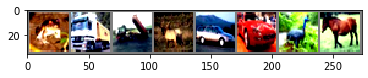

In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(tv.utils.make_grid(images))

The next cell should be in models/model1.py

In [6]:
# Writing our model
class Autoencoder(nn.Module):    
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(6,16,kernel_size=5),
            nn.ReLU(True))        
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(16,6,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,3,kernel_size=5),
            nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [26]:
from torchsummary import summary
summary(Autoencoder(), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 16, 24, 24]           2,416
              ReLU-4           [-1, 16, 24, 24]               0
   ConvTranspose2d-5            [-1, 6, 28, 28]           2,406
              ReLU-6            [-1, 6, 28, 28]               0
   ConvTranspose2d-7            [-1, 3, 32, 32]             453
              ReLU-8            [-1, 3, 32, 32]               0
Total params: 5,731
Trainable params: 5,731
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.33
Params size (MB): 0.02
Estimated Total Size (MB): 0.36
----------------------------------------------------------------


In [7]:
#defining some params
num_epochs = 2 #you can go for more epochs
batch_size = 128

In [8]:
model = Autoencoder().cpu()
distance = nn.MSELoss() #We can modify this, eg input and output must have same edges, we should experiment differents ones
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

The 2 next cells should be in train.py inside a def train(model, loss, trainloader, groundtruthes, params):

In [9]:
for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        img = Variable(img).cpu()
        # ===================forward=====================
        output = model(img)
        groundtruth = img #In order to transform "north" to "south", our inputs can be the "north" images, groundtruth is corresponding "south" image
        loss = distance(output, groundtruth)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data))
print('Finished Training')

epoch [1/2], loss:0.3845
epoch [2/2], loss:0.3822
Finished Training


A part of the next cell should be in utils/save_model.py

In [10]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

The 4 next cells should be in test.py inside a def test(model, trained_state, testloader, groundtruthes, params):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


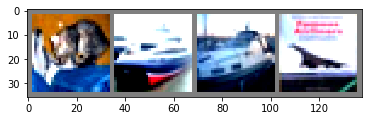

In [16]:
dataiter = iter(testloader)
images, _ = dataiter.next()
# print images
imshow(tv.utils.make_grid(images))

In [17]:
model = Autoencoder().cpu()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
outputs = model(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


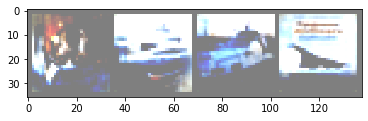

In [21]:
# print images
imshow(tv.utils.make_grid(outputs.detach()))